# Extracting data from President Dataset  

We have found president data set at the source https://dataverse.harvard.edu/file.xhtml?fileId=10244938&version=8.0.  

It contains results of presidental elections (number of votes per each candidate) per state from 1976 to 2020.  

Columns dataset contains are:

* `year` - year in which elections are held
* `office` - U.S. PRESIDENT
* `state` - state name
* `state_po` - U.S. postal code state abbreviation
* `state_fips` - state FIPS code
* `state_cen` - U.S. Census state code
* `state_ic` - ICPSR state code
* `candidate` - name of the candidate
* `party_detailed` - party of the candidate
* `party_simplified` - party of the candidate (one of DEMOCRAT, REPUBLICAN, LIBERTARIAN, OTHER)
* `writein` - vote totals associated with write-in candidates (TRUE - write-in candidates, FALSE - non-write-in candidates)
* `candidatevotes` - votes received by this candidate for this particular party
* `totalvotes` - total number of votes cast for this election

In [1]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd

In [2]:
file_path = pathlib.Path("data") / "1976-2020-president.csv"
president_data = pd.read_csv(file_path)

In [3]:
president_data.head(5)

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER


Our beer reviews dataset contains data from 2001 to 2017. Therefore, we need to filter out the election data to span the same years.  

Also, we are going to drop the columns that are irrelevant for our analysis. We are keeping: year, state, party simplified, candidate votes and total votes. Only possible entries for party simplified are: REPUBLICAN, DEMOCRAT, LIBERTARIAN, OTHER. Since can be multiple candidates in each state that belong to the same party, we will sum all the votes corresponding to the same party per each state.

In [4]:
pr_df = president_data.copy()

# Filter out years
pr_df_filt = pr_df[(pr_df['year'] >= 2001) & (pr_df['year'] <= 2017)]

# Filter out irrelevant columns
relevant_columns = ['year', 'state', 'party_simplified', 'candidatevotes', 'totalvotes']
pr_df_filt = pr_df_filt[relevant_columns]

parties = pr_df_filt['party_simplified'].unique()

# Collect all OTHER candidates per each state - sum their votes
def sum_the_votes(parties, pr_df_filt):
    
    for party in parties:
        
        pr_df_filt_other = pr_df_filt[pr_df_filt['party_simplified'] == party].groupby(['state', 'year']).agg({'candidatevotes' : 'sum', 'totalvotes' : 'first'}).reset_index()
        pr_df_filt_other['party_simplified'] = party
        
        pr_df_non_other = pr_df_filt[pr_df_filt['party_simplified'] != party]
        pr_df_filt = pd.concat([pr_df_non_other, pr_df_filt_other])
    
    return pr_df_filt
    
pr_df_combined = sum_the_votes(parties, pr_df_filt)

In [7]:
pr_df_combined.head(5)

,year,state,party_simplified,candidatevotes,totalvotes
0,2004,ALABAMA,REPUBLICAN,1176394,1883415
1,2008,ALABAMA,REPUBLICAN,1266546,2099819
2,2012,ALABAMA,REPUBLICAN,1255925,2074338
3,2016,ALABAMA,REPUBLICAN,1318255,2123372
4,2004,ALASKA,REPUBLICAN,190889,312598


For sanity check, we are curious to see if the dataset is complete, meaning having the same number of states for each year (only interested in elections of year 2004, 2008, 2012 and 2016).

In [25]:
states_2004 = set(pr_df_combined[pr_df_combined['year'] == 2004]['state'].unique())
states_2008 = set(pr_df_combined[pr_df_combined['year'] == 2008]['state'].unique())
states_2012 = set(pr_df_combined[pr_df_combined['year'] == 2012]['state'].unique())
states_2016 = set(pr_df_combined[pr_df_combined['year'] == 2016]['state'].unique())

# Check if the sets of states are the same for all years
if states_2004 == states_2008 == states_2012 == states_2016:
    print(f"All years have the same states: {len(states_2004)} states.")
else:
    print("Mismatch detected!")

All years have the same states: 51 states.


Now, we want to establish new columns: one for each party_simplified which will contain percentage of votes each party got.

In [6]:
pr_df_combined['percentage'] = (pr_df_combined['candidatevotes'] / pr_df_combined['totalvotes']) * 100
pr_df_percentage = pr_df_combined.drop(['candidatevotes', 'totalvotes'], axis=1, inplace=False)
pr_df_percentage.head(5)

,year,state,party_simplified,percentage
0,2004,ALABAMA,REPUBLICAN,62.460690
1,2008,ALABAMA,REPUBLICAN,60.316913
2,2012,ALABAMA,REPUBLICAN,60.545822
3,2016,ALABAMA,REPUBLICAN,62.083092
4,2004,ALASKA,REPUBLICAN,61.065330


In [7]:
pr_df_percentage.head(50)

,year,state,party_simplified,percentage
0,2004,ALABAMA,REPUBLICAN,62.460690
1,2008,ALABAMA,REPUBLICAN,60.316913
2,2012,ALABAMA,REPUBLICAN,60.545822
3,2016,ALABAMA,REPUBLICAN,62.083092
4,2004,ALASKA,REPUBLICAN,61.065330
5,2008,ALASKA,REPUBLICAN,59.424520
6,2012,ALASKA,REPUBLICAN,54.801577
7,2016,ALASKA,REPUBLICAN,51.281512
8,2004,ARIZONA,REPUBLICAN,54.869434
9,2008,ARIZONA,REPUBLICAN,53.635248


## Statistics over year, parties etc.

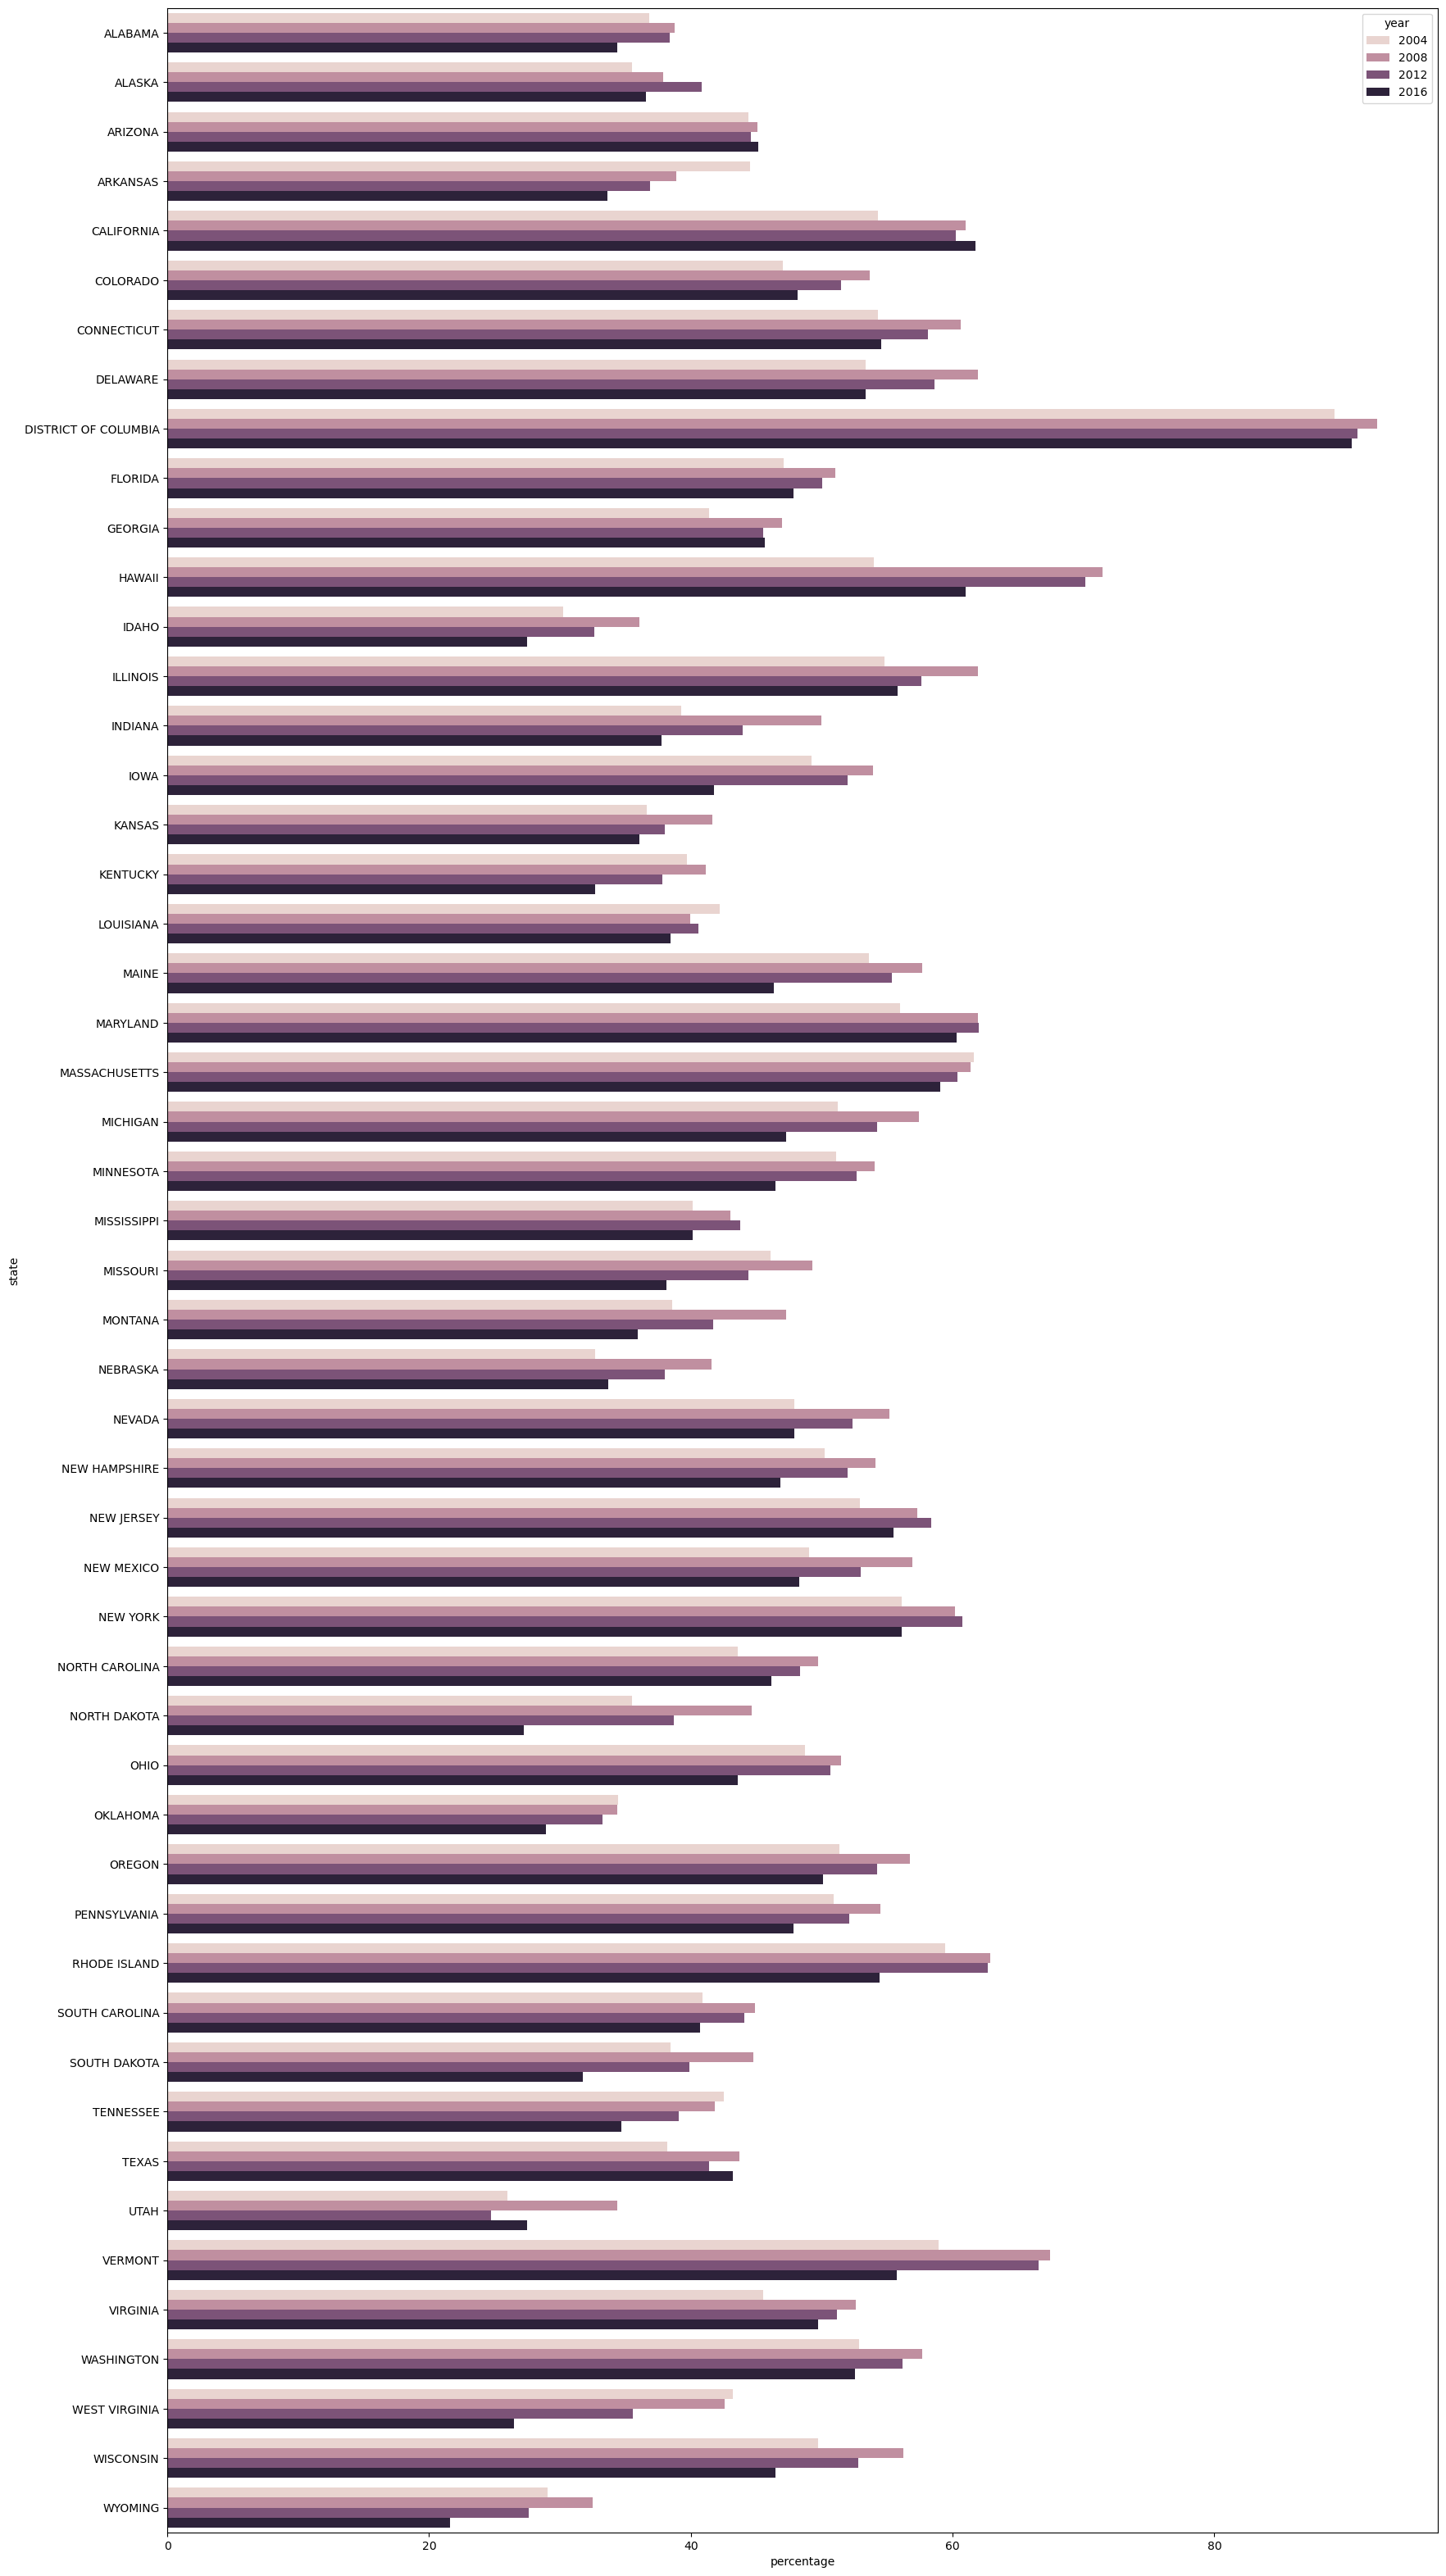

In [8]:
pr_df_democrats = pr_df_percentage[pr_df_percentage['party_simplified'] == 'DEMOCRAT']
pr_df_republican = pr_df_percentage[pr_df_percentage['party_simplified'] == 'REPUBLICAN']

plt.figure(figsize=(20,40))
bar1 = sns.barplot(pr_df_democrats, x='percentage', y='state', hue='year', errorbar=None)

<Axes: xlabel='percentage', ylabel='state'>

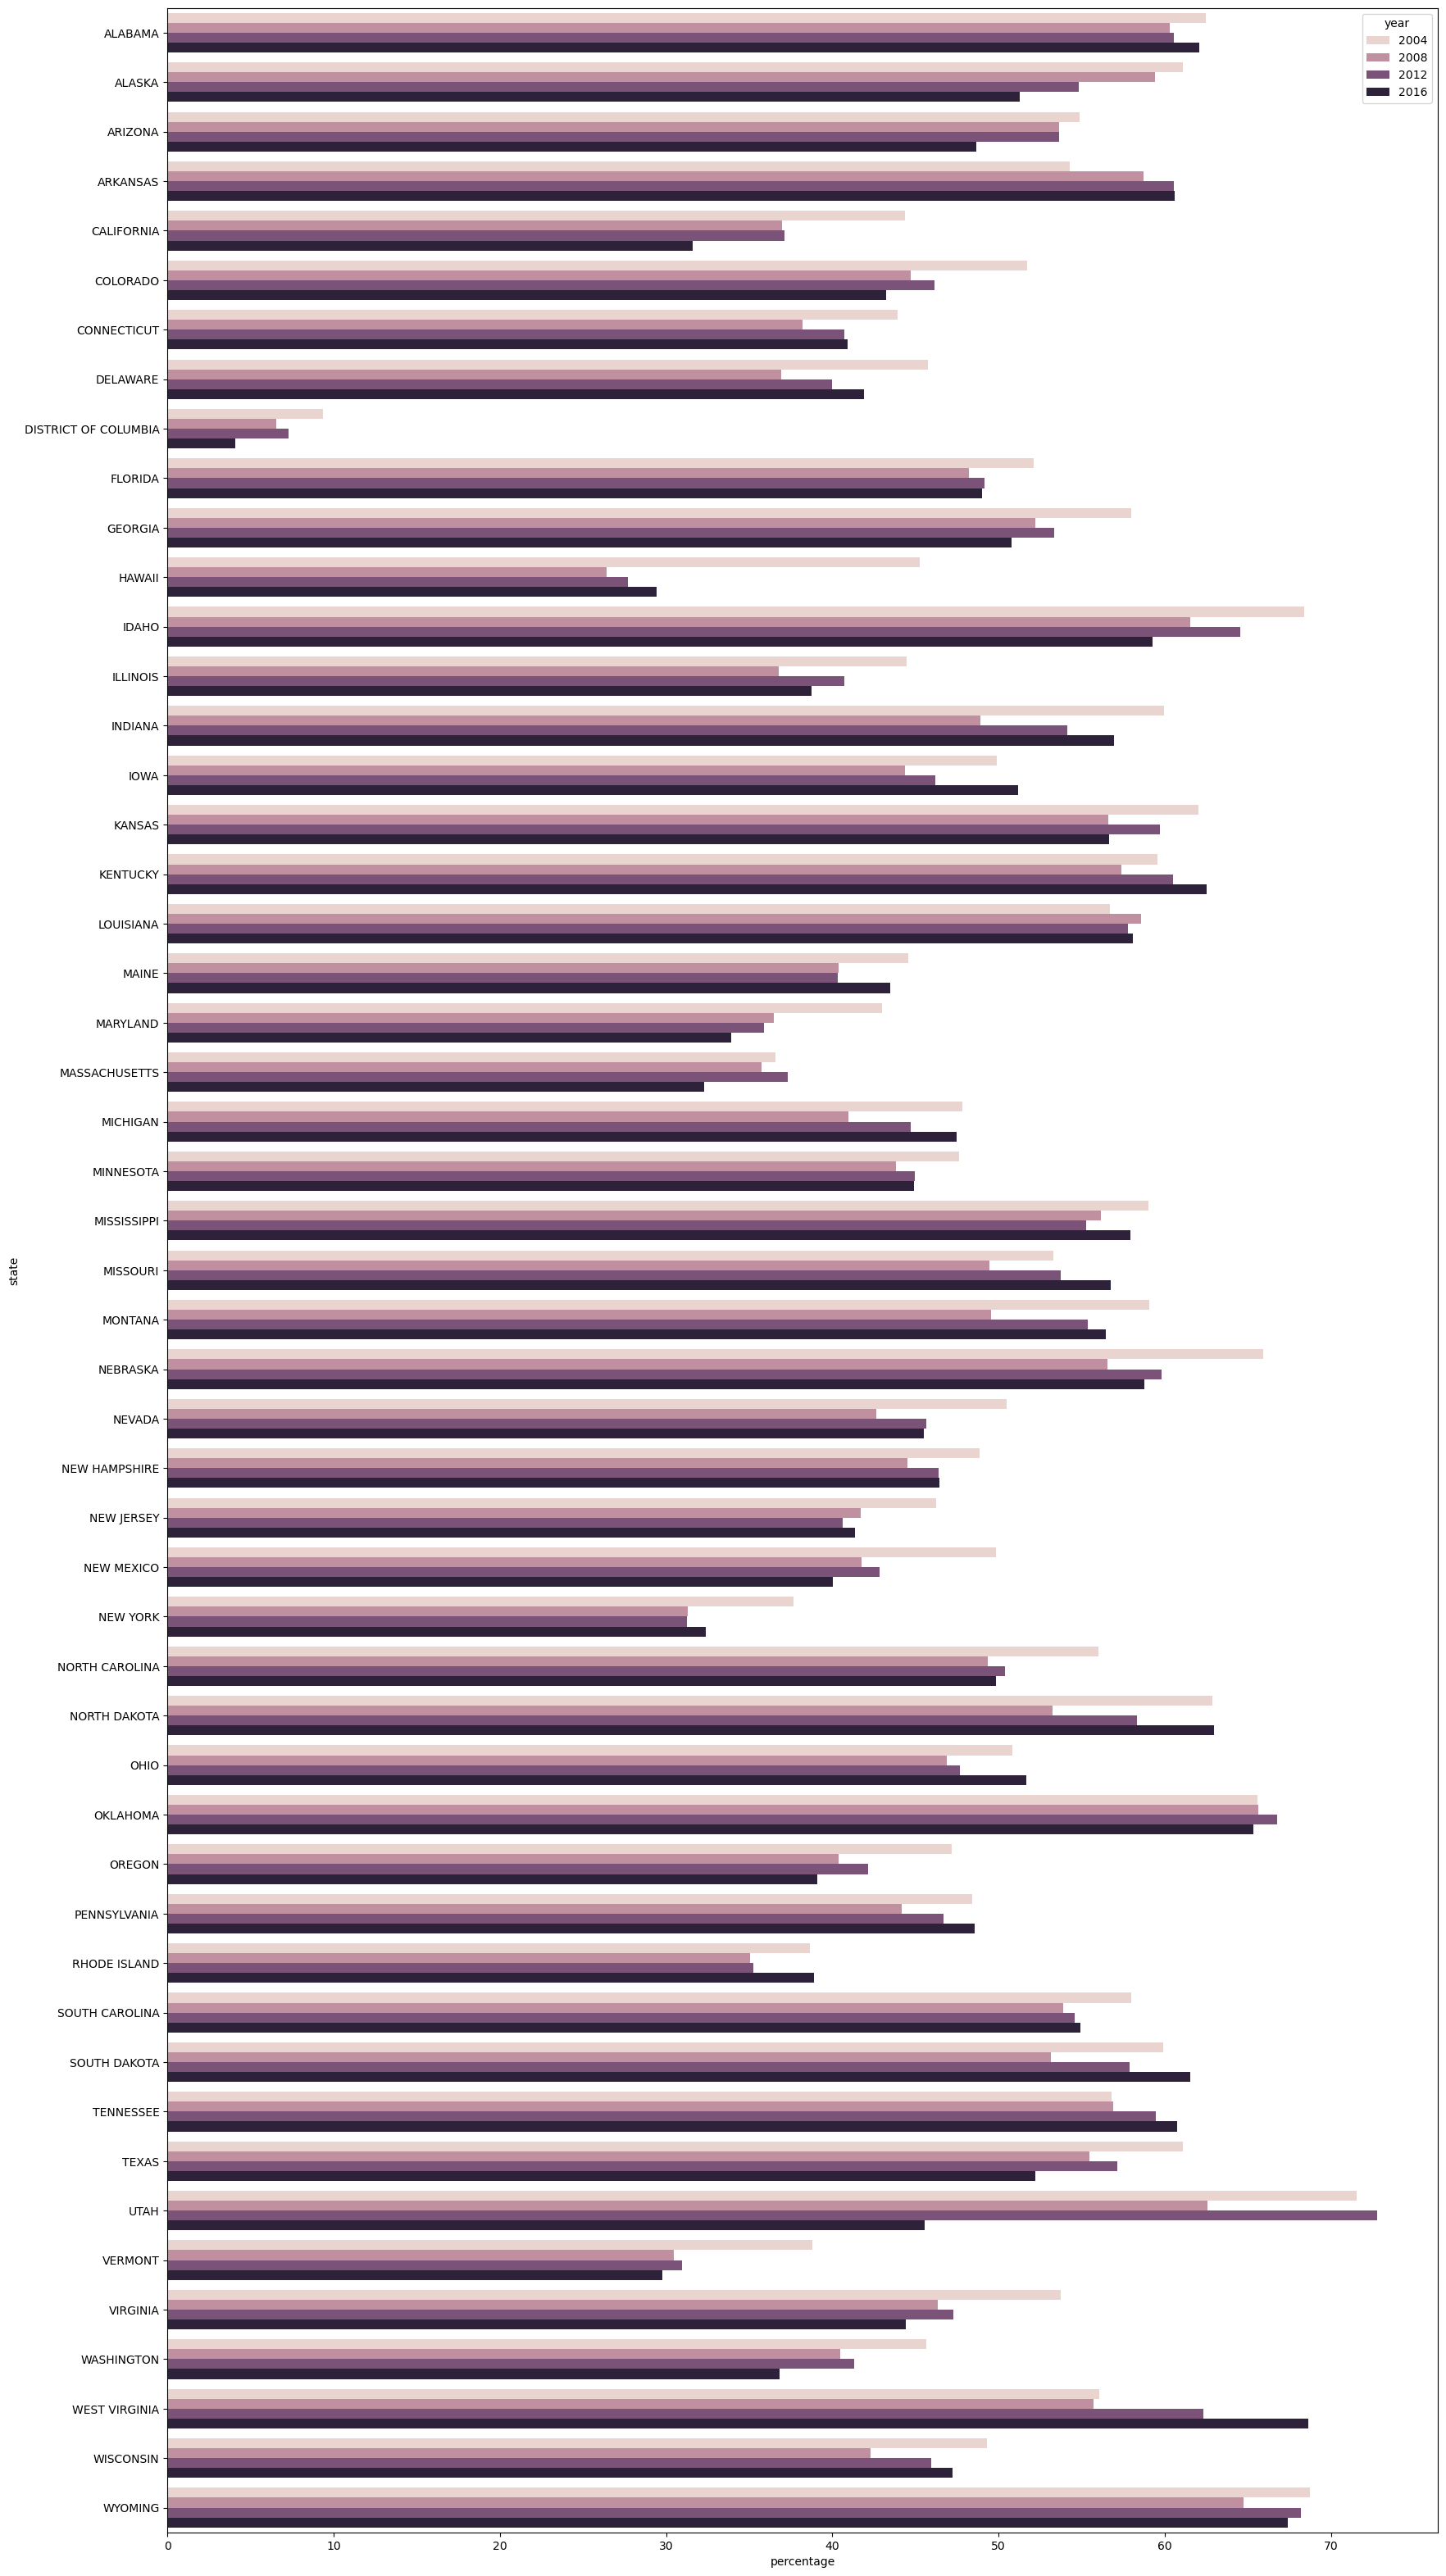

In [9]:
plt.figure(figsize=(20, 40))
sns.barplot(pr_df_republican, x='percentage', y='state', hue='year')

It is interesting to also check which states (if they exist) changed their opinion from one party to another - so called swing states.

In [10]:
pr_df = pd.pivot_table(pr_df_percentage, columns=['party_simplified'], values='percentage', index=['state', 'year']).reset_index()

In [11]:
winner = pr_df[['DEMOCRAT', 'OTHER', 'LIBERTARIAN', 'REPUBLICAN']].idxmax(axis=1)
pr_df['winner'] = winner
pr_df.head(20)

party_simplified,state,year,DEMOCRAT,LIBERTARIAN,OTHER,REPUBLICAN,winner
0,ALABAMA,2004,36.844402,NaN,0.694908,62.460690,REPUBLICAN
1,ALABAMA,2008,38.740434,NaN,0.942653,60.316913,REPUBLICAN
2,ALABAMA,2012,38.359033,NaN,1.095145,60.545822,REPUBLICAN
3,ALABAMA,2016,34.357946,2.094169,1.464793,62.083092,REPUBLICAN
4,ALASKA,2004,35.516862,0.535832,2.881976,61.065330,REPUBLICAN
5,ALASKA,2008,37.889374,0.487129,2.198978,59.424520,REPUBLICAN
6,ALASKA,2012,40.812659,2.459941,1.925822,54.801577,REPUBLICAN
7,ALASKA,2016,36.550871,5.877128,6.290489,51.281512,REPUBLICAN
8,ARIZONA,2004,44.396833,0.589093,0.144640,54.869434,REPUBLICAN
9,ARIZONA,2008,45.115251,0.547423,0.702079,53.635248,REPUBLICAN


In [17]:
pr_df.to_csv('party_winners_over_years.csv')

In [12]:
# Based on winners classify states in 3 categories - SWING, DEMOCRAT, REPUBLICAN
# We consider party swing if it changed from one party to another (across 4 elections)
states = list(pr_df['state'].unique())
party = []
for state in states:
    winners = pr_df[pr_df['state'] == state]['winner']
    if len(winners.unique()) > 1:
        party.append('SWING')
    else:
        party.append(winners.unique()[0])
        
# Create dictionary
data = {'state' : states, 'party' : party}
data_plot = pd.DataFrame(data)
data_plot['state'] = data_plot['state'].str.title()

In [15]:
data_plot.to_csv('party_winners.csv')

In [16]:
data_plot

,state,party
0,Alabama,REPUBLICAN
1,Alaska,REPUBLICAN
2,Arizona,REPUBLICAN
3,Arkansas,REPUBLICAN
4,California,DEMOCRAT
5,Colorado,SWING
6,Connecticut,DEMOCRAT
7,Delaware,DEMOCRAT
8,District Of Columbia,DEMOCRAT
9,Florida,SWING
